In [20]:
import numpy as np # linear algebra
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
from PIL import Image
import random

In [21]:
def get_training_data(image_path):
    """Loads an image from the given path into a numpy array."""
    with Image.open(image_path) as img:
        return np.array(img)

### Specify directories

In [22]:
X_dir = 'Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/images'
y_dir = 'Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/maskpngs'

### Visualization of data

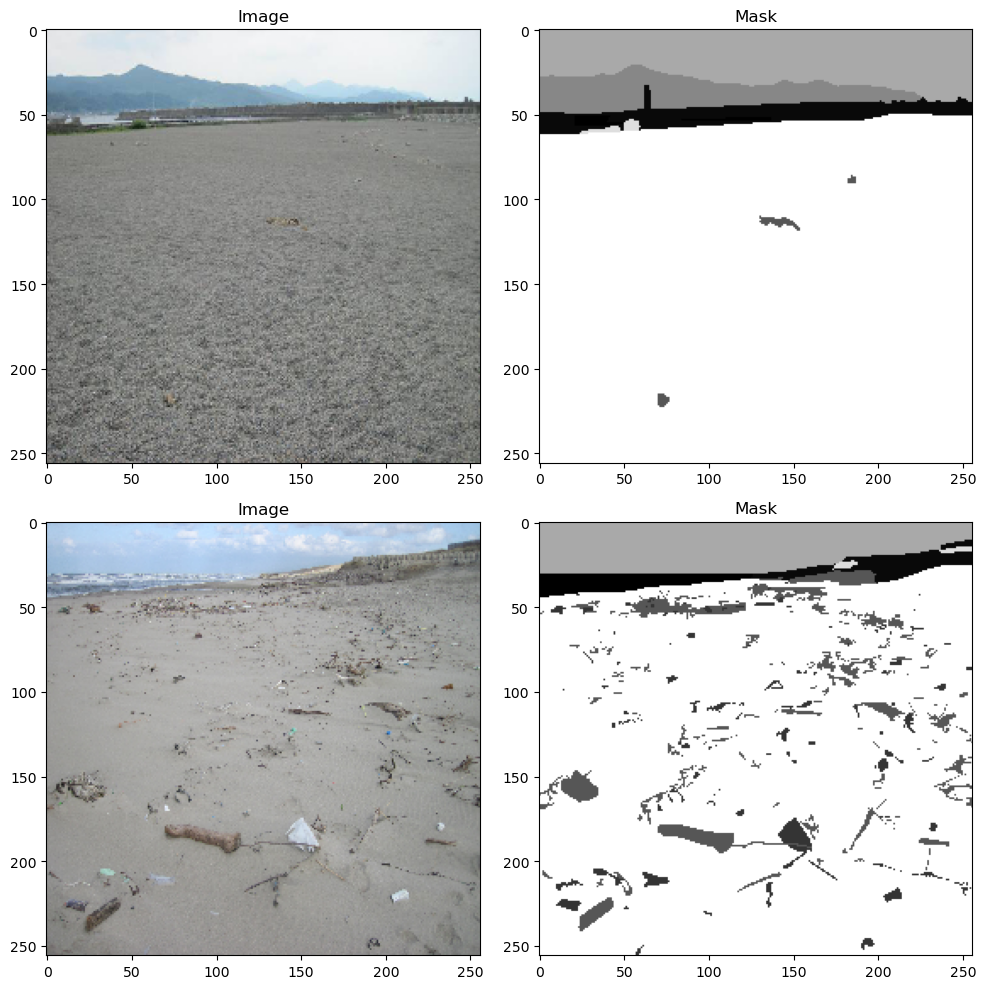

In [24]:
def visualize_data(image_dir, mask_dir, num_examples=2):
    image_files = os.listdir(image_dir)
    mask_files = {os.path.splitext(f)[0]: f for f in os.listdir(mask_dir)}
    
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, num_examples * 5))
    
    for i in range(num_examples):
        img_name = random.choice(image_files)
        img_base_name = os.path.splitext(img_name)[0]
        
        img_path = os.path.join(image_dir, img_name)
        mask_name = mask_files.get(img_base_name, None)
        
        if not mask_name:
            print(f"Mask not found for {img_name}")
            continue
        
        mask_path = os.path.join(mask_dir, mask_name)
        
        image = img_to_array(load_img(img_path, target_size=(256, 256))) / 255.0
        mask = img_to_array(load_img(mask_path, target_size=(256, 256), color_mode='grayscale')) / 255.0
        
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Mask')
        
    plt.tight_layout()
    plt.show()

visualize_data('./Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/images', './Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/maskpngs')


### Process images - Research paper states 4:3 aspect ratio for more than 95% of the images

In [27]:
target_width = 400  # 4:3 aspect ratio as given by the research file
target_height = 300

def resize_and_crop(image_path, output_path):
    img = cv2.imread(image_path)
    height, width, _ = img.shape
    aspect_ratio = width / float(height)

    if aspect_ratio > 4/3:
        new_width = int(target_height * aspect_ratio)
        img = cv2.resize(img, (new_width, target_height), interpolation=cv2.INTER_AREA)
        start = (new_width - target_width) // 2
        img = img[:, start:start + target_width]
    else:
        new_height = int(target_width / aspect_ratio)
        img = cv2.resize(img, (target_width, new_height), interpolation=cv2.INTER_AREA)
        start = (new_height - target_height) // 2
        img = img[start:start + target_height, :]

    cv2.imwrite(output_path, img)

In [28]:
# Iterate over images in X_dir and y_dir, apply resize_and_crop function
for filename in os.listdir(X_dir):
    if filename.endswith(".jpg"):  
        img_path = os.path.join(X_dir, filename)
        output_path = os.path.join(X_dir, f"resized_{filename}")  # Example output path, adjust as needed
        resize_and_crop(img_path, output_path)

for filename in os.listdir(y_dir):
    if filename.endswith(".jpg"): 
        img_path = os.path.join(y_dir, filename)
        output_path = os.path.join(y_dir, f"resized_{filename}")  # Example output path, adjust as needed
        resize_and_crop(img_path, output_path)

### Splitting the data and augmenting

In [32]:
os.listdir(y_dir)

['000000.png',
 '000001.png',
 '000002.png',
 '000003.png',
 '000004.png',
 '000005.png',
 '000006.png',
 '000007.png',
 '000008.png',
 '000009.png',
 '000010.png',
 '000011.png',
 '000012.png',
 '000013.png',
 '000014.png',
 '000015.png',
 '000016.png',
 '000017.png',
 '000018.png',
 '000019.png',
 '000020.png',
 '000021.png',
 '000022.png',
 '000023.png',
 '000024.png',
 '000025.png',
 '000026.png',
 '000027.png',
 '000028.png',
 '000029.png',
 '000030.png',
 '000031.png',
 '000032.png',
 '000033.png',
 '000034.png',
 '000035.png',
 '000036.png',
 '000037.png',
 '000038.png',
 '000039.png',
 '000040.png',
 '000041.png',
 '000042.png',
 '000043.png',
 '000044.png',
 '000045.png',
 '000046.png',
 '000047.png',
 '000048.png',
 '000049.png',
 '000050.png',
 '000051.png',
 '000052.png',
 '000053.png',
 '000054.png',
 '000055.png',
 '000056.png',
 '000057.png',
 '000058.png',
 '000059.png',
 '000060.png',
 '000061.png',
 '000062.png',
 '000063.png',
 '000064.png',
 '000065.png',
 '000066.p

In [30]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_dir, y_dir, test_size=0.4, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

ValueError: Found input variables with inconsistent numbers of samples: [65, 67]

In [31]:
y_dir

'Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/maskpngs'